

 Pilnai paruoštai klientų segmentavimo sistemai reikalingi du failai („train_segmentation.py“ ir „predict_segment.py“). Štai kodėl ir kaip jie veikia kartu:
1. Dviejų failų sistemos architektūra




2. Kodėl abu failai yra būtini?
- train_segmentation.py
Šis failas naudojamas klientų segmentavimo modeliui treniruoti. Jis analizuoja istorinius duomenis, nustato modelio parametrus ir sukuria išsaugotą segmentavimo modelį, kurį vėliau galima taikyti naujiems klientams.
- Kada vykdyti?
- Pradiniame etape, kai kuriamas segmentavimo modelis.
- Kai duomenys atnaujinami, kad modelis išliktų tikslus.
- Periodiškai (pvz., kas mėnesį), siekiant optimizuoti segmentavimo rezultatus.
- Išvestis:
- Modelio failai (.joblib), kurie vėliau naudojami naujų klientų segmentavimui.
- predict_segment.py
Šis failas taiko jau treniruotą modelį, kad priskirtų naujus klientus vienam iš nustatytų segmentų. Jis veikia pagal anksčiau išmoktas taisykles ir greitai suteikia kiekvienam klientui tinkamą segmentą.
- Kada vykdyti?
- Kai atsiranda nauji užsakymai, kad klientai būtų automatiškai segmentuojami.
- Realiu laiku, kai sistema gauna naujus duomenis apie klientus.
- Išvestis:
- Kliento segmentas (nuo 0 iki 3), kuris parodo jo elgseną ir padeda pritaikyti personalizuotas rinkodaros strategijas.
Apibendrinimas:
Šie du failai dirba kartu – vienas treniruoja segmentavimo modelį, o kitas taiko jį naujiems klientams. Tai leidžia sukurti veiksmingą, nuolat atnaujinamą segmentavimo sistemą, kuri padeda optimizuoti verslo sprendimus ir geriau suprasti klientų elgseną.


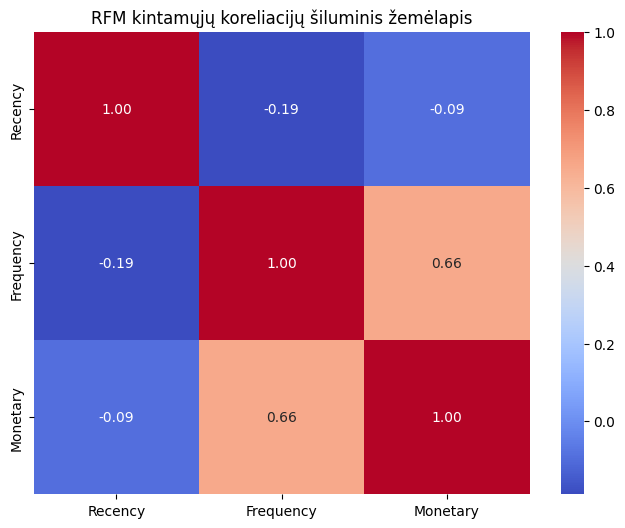

Model trained and saved successfully!


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(filepath):
    """Load and preprocess retail data"""
    df = pd.read_csv(filepath, parse_dates=['InvoiceDate'])
    current_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
    
    # Calculate RFM
    rfm = df.groupby('Customer_ID').agg({
        'InvoiceDate': lambda x: (current_date - x.max()).days,
        'Invoice': 'nunique',
        'Revenue': 'sum'
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'Invoice': 'Frequency',
        'Revenue': 'Monetary'
    })
    
    return rfm

def train_model(rfm_data, n_clusters=4):
    """Train and save segmentation model"""
    # Log transformation
    rfm_log = np.log1p(rfm_data[['Recency', 'Frequency', 'Monetary']])
    
    # Standardization
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_log)
    
    # Train KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(rfm_scaled)
    
    # Save artifacts
    joblib.dump(kmeans, 'models/segment_kmeans.joblib')
    joblib.dump(scaler, 'models/segment_scaler.joblib')
    
    return kmeans, scaler



if __name__ == "__main__":
    # Append new data to historical
    new_data = pd.read_csv('data/new_transactions.csv')
    historical = pd.read_csv('data/processed/cleaned_online_retail.csv')
    updated_data = pd.concat([historical, new_data])
    updated_data.to_csv('data/processed/cleaned_online_retail.csv', index=False)
    
    # Now train
    rfm_data = load_data('data/processed/cleaned_online_retail.csv')



    plt.figure(figsize=(8,6))
    sns.heatmap(rfm_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("RFM kintamųjų koreliacijų šiluminis žemėlapis")
    plt.show()





    model, scaler = train_model(rfm_data)

    print("Model trained and saved successfully!")


In [2]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime

class CustomerSegmenter:
    def __init__(self):
        self.model = joblib.load('models/segment_kmeans.joblib')
        self.scaler = joblib.load('models/segment_scaler.joblib')
    
    def calculate_rfm(self, transaction_data, customer_id):
        """Calculate RFM metrics for a specific customer using your exact format"""
        # Convert to datetime if not already
        transaction_data['InvoiceDate'] = pd.to_datetime(transaction_data['InvoiceDate'])
        
        current_date = transaction_data['InvoiceDate'].max() + pd.DateOffset(days=1)
        
        # Filter for customer and calculate metrics
        customer_data = transaction_data[transaction_data['Customer_ID'] == customer_id]
        
        if customer_data.empty:
            return None
            
        rfm = pd.DataFrame({
            'Recency': (current_date - customer_data['InvoiceDate'].max()).days,
            'Frequency': customer_data['Invoice'].nunique(),
            'Monetary': customer_data['Revenue'].sum()
        }, index=[0])
        
        return rfm
    
    def predict_segment(self, rfm_data):
        """Predict customer segment"""
        # Transformations
        rfm_log = np.log1p(rfm_data)
        rfm_scaled = self.scaler.transform(rfm_log)
        
        # Prediction
        segment = self.model.predict(rfm_scaled)[0]
        return segment

# Example usage with YOUR data format:
if __name__ == "__main__":
    # Load new transaction data (with your exact format)
    try:
        new_data = pd.read_csv('data/new_transactions.csv', 
                             parse_dates=['InvoiceDate'])
        print("Data loaded successfully. Sample:")
        print(new_data.head())
        
        # Get first customer ID in data for testing
        test_customer = new_data['Customer_ID'].iloc[0]
        print(f"\nTesting with customer ID: {test_customer}")
        
        # Initialize and predict
        segmenter = CustomerSegmenter()
        customer_rfm = segmenter.calculate_rfm(new_data, test_customer)
        
        if customer_rfm is not None:
            print("\nCalculated RFM values:")
            print(customer_rfm)
            
            segment = segmenter.predict_segment(customer_rfm)
            print(f"\nPredicted segment: {segment}")
            
            # Segment interpretation guide
            segments = {
                0: "Low-Value",
                1: "Mid-Value",
                2: "High-Value",
                3: "Champions"
            }
            print(f"Segment meaning: {segments.get(segment, 'Unknown')}")
        else:
            print("Error: Customer not found in data")
            
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Please verify:")
        print("- File exists at 'data/new_transactions.csv'")
        print("- Columns match: Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Revenue")

Data loaded successfully. Sample:
   Invoice  StockCode          Description  Quantity         InvoiceDate  \
0   538172      21877  HOME SWEET HOME MUG        10 2025-05-20 23:59:18   
1   538173      21877  HOME SWEET HOME MUG        10 2025-05-21 00:11:55   

   Price  Customer_ID         Country  Revenue  
0   1.25        99100  United Kingdom     12.5  
1   1.25        99100  United Kingdom     12.5  

Testing with customer ID: 99100

Calculated RFM values:
   Recency  Frequency  Monetary
0        1          2      25.0

Predicted segment: 1
Segment meaning: Mid-Value


Segmentavimo proceso paaiškinimas
Rezultatas po treniravimo (train_segmentation.py)
Kai modelis yra apmokytas, jis išsaugomas ir paruoštas naudoti:
✔ Model trained and saved successfully! (Modelis sėkmingai ištreniruotas ir išsaugotas)
B. Prognozavimo etapas (predict_segment.py)
Įvestis: Nauji klientų duomenys (new_transactions.csv)
Procesas:
- Įkeliami išsaugoti K-Means modelis ir duomenų skaleris
- Apskaičiuojami RFM rodikliai (Recency, Frequency, Monetary) naujiems klientams
- Naudojamas treniruotas modelis klientų segmentų prognozavimui
Išvestis:
✔ Predicted segment: 2 (High-Value) (Nuspėtas segmentas – 2, aukštos vertės klientas)

3. Svarbūs paaiškinimai
✅ Nepriklausomumas nuo kmeans_segment.py
Jūsų segmentavimo sistema yra visiškai autonomiška ir veikia tik su train_segmentation.py ir predict_segment.py.
Ankstesni K-Means duomenys dabar yra užfiksuoti:
- models/segment_kmeans.joblib (ištreniruotas modelis)
- models/segment_scaler.joblib (duomenų normalizavimo įrankis)

4. Kada reikia papildomų skriptų?
Tik tuo atveju, jei norite išplėsti funkcionalumą:
- Modelio stebėjimas – monitor_drift.py (sekimas, ar modelio tikslumas laikui bėgant blogėja)
- Išsami analizė – segment_analysis.py (giluminė segmentų analizė)
- API integracija – flask_api.py (interneto paslauga, skirta segmentų prognozėms)

🔹 Apibendrinimas:
Sistema automatiškai segmentuoja naujus klientus ir prognozuoja jų elgseną remdamasi K-Means modeliu. Norint papildyti funkcionalumą, galima įdiegti modelio stebėjimą, gilesnę analizę ar API integraciją.
